In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
from scipy.constants import hbar, pi, e, m_e, epsilon_0
from scipy.integrate import quad
from functools import lru_cache

# Equilateral Triangle
![Equilateral Triangle](https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Equilateral-triangle-heights.svg/552px-Equilateral-triangle-heights.svg.png)

The side lengths are equal $a=b=c$ and the angles $\alpha=\beta=\gamma=60^{\circ}$. This also gives us that $h_a=h_b=h_c$.

We can find the total height h using trigonometri. $\sin(60^\circ) = \frac{h}{a}$ or $h = L\sin(60^\circ) = \frac{\sqrt{3}L}{2}$.
We can also find $h_a$ in a similar way, $\cos(30^\circ)=\frac{a/2}{h_a}$ or $h_a = \frac{L/2}{cos(30^\circ)}=\frac{L}{\sqrt{3}}$.
The distance from the center to one of the sides at a right angle is then $h = h_a + h_v$ or $h_v = \frac{a}{2\sqrt{3}}$.

# Emitters
We then place a square emitter in the center of the triangle. The center of the square coincides with the center of the triangle. We also place emitters at the three corners of the triangle. Each emitter has side length $L$ and there centers placed at the corners.

## Coordinates of centers
Lets find the coordinates of the triangles corners of the triangle and its center. We define a coordinate system with the origin at the center of the triangle.
The center therefore has the coordinates (0, 0), the corner C then has the coordinates (0, h_c), A has (-a/2, -h_v) and B (+a/2, -h_v).

## Coordinates of emitters
We need to find the coordinates of the lower left corner of all the emitters, because we want to integrate over them. If we know the center coordinate of the emitter then the coordinate of the lower left corner will be, (x_0 - L/2, y_0 - L/2). That is we just subtract half the side length of the emitter.

In [19]:
def Triangle_emitters(a: float):
    # Parameters for triangle
    #a = 1000.0 # Triangle side length [nm]
    h = np.sqrt(3)*a/2 # Height of triangle
    h_a = a/np.sqrt(3) # Distance from corner to center
    h_v = a/(2*np.sqrt(3))

    # Center coordinates
    x_0 = 0.0
    y_0 = 0.0

    # A coordinates
    x_a = -a/2
    y_a = -h_v

    # B coordinates
    x_b = +a/2
    y_b = -h_v

    # C coordinates
    x_c = 0.0
    y_c = h_a
    
    len_x = 20.0
    len_y = 20.0
    
    x_coor = np.array([])
    y_coor = np.array([])
    
    for i in range(-2, 2+1):
        for j in range(-2, 2+1):
            x_new = x_0 + len_x*i
            y_new = y_0 + len_y*j
            x_coor = np.append(x_coor, x_new)
            y_coor = np.append(y_coor, y_new)
            
    for i in range(-2, 2+1):
        for j in range(-2, 2+1):
            x_new = x_a + len_x*i
            y_new = y_a + len_y*j
            x_coor = np.append(x_coor, x_new)
            y_coor = np.append(y_coor, y_new)
            
    for i in range(-2, 2+1):
        for j in range(-2, 2+1):
            x_new = x_b + len_x*i
            y_new = y_b + len_y*j
            x_coor = np.append(x_coor, x_new)
            y_coor = np.append(y_coor, y_new)
    
    for i in range(-2, 2+1):
        for j in range(-2, 2+1):
            x_new = x_c + len_x*i
            y_new = y_c + len_y*j
            x_coor = np.append(x_coor, x_new)
            y_coor = np.append(y_coor, y_new)
    
    #x_coor = np.array([x_0, x_a, x_b, x_c])
    #y_coor = np.array([y_0, y_a, y_b, y_c])
    
    nrEmit = len(x_coor)
    
    side_len_x = np.ones(nrEmit)*len_x
    side_len_y = np.ones(nrEmit)*len_y
    work_fun   = np.ones(nrEmit)*2.2
    
    return x_coor, y_coor, side_len_x, side_len_y, work_fun

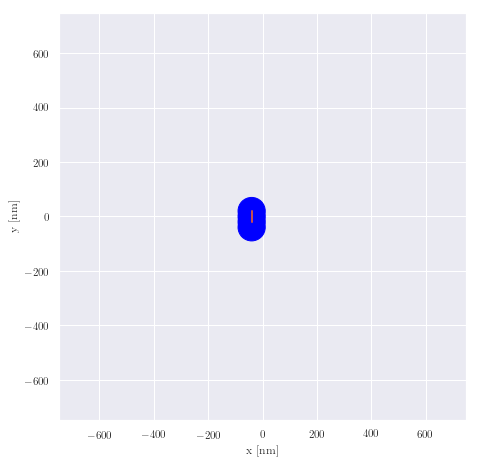

In [20]:
a = 1000.0
x_coor, y_coor, _, _, _ = Triangle_emitters(a)

x_0 = x_coor[0]
x_a = x_coor[1]
x_b = x_coor[2]
x_c = x_coor[3]

y_0 = y_coor[0]
y_a = y_coor[1]
y_b = y_coor[2]
y_c = y_coor[3]

# Draw the triangle
plt.rc('font', family='serif', size=16)
plt.rcParams['figure.figsize'] = [10, 7.5]

fig = plt.figure()
ax = plt.subplot(111)

circle_0 = plt.Circle((x_0, y_0), a*0.05, color='blue')
circle_a = plt.Circle((x_a, y_a), a*0.05, color='blue')
circle_b = plt.Circle((x_b, y_b), a*0.05, color='blue')
circle_c = plt.Circle((x_c, y_c), a*0.05, color='blue')

ax.add_artist(circle_0)
ax.add_artist(circle_a)
ax.add_artist(circle_b)
ax.add_artist(circle_c)

ax.set_aspect('equal')

ax.set_xlim([-0.75*a, 0.75*a])
ax.set_ylim([-0.75*a, 0.75*a])

ax.set_xlabel('x [nm]')
ax.set_ylabel('y [nm]')

ax.plot([x_a, x_b, x_c, x_a], [y_a, y_b, y_c, y_a], 'r-')

plt.show()

# Fluid model
This code calculates the fluid model for the field emission.

The continuity equation, $\rho(z) \frac{p}{m_e} = J$

Conservation of energy, $\frac{p^2}{2m_e} = eV_0 \frac{z}{d}$

Combined they give, $\rho(z) = \frac{J}{\sqrt{z}} \sqrt{\frac{md}{2eV}}$

In [21]:
# Constants
a_FN = e**2/(16*pi**2*hbar) # First Fowler Nodheim constant
b_FN = -4/(3*hbar) * np.sqrt(2*m_e*e) # Second Fowler Nordheim constant
l_const = e / (4*pi*epsilon_0) # Constant for image charge calculations
x = 0.15 # Mixing weight in iteration
MAX_ITER = 500 # Maximum number of iterations before giving upp

# System parameters
V = 1.0 # Voltage [V]
d = 1.0 # Gap spacing [nm]

E_vac = V / (d*1.0E-9) # [V/m]

# Scale the current density with the Child-Langmuir law in 1D
J_CL1D = 4/9*epsilon_0*np.sqrt(2*e/m_e)*V**(3/2)/(d*1.0E-9)**2

def Set_System(V_: float, d_: float):
    global V, d, E_vac, J_CL1D
    V = V_
    d = d_
    E_vac = V/(d*1.0E-9)
    J_CL1D = 4/9*epsilon_0*np.sqrt(2*e/m_e)*V**(3/2)/(d*1.0E-9)**2

# Use this function to set system parameters
Set_System(2250, 1000.0)

In [22]:
# Functions

# Approximations to the eleptical integrals for the image-charge effect
# in the Fowler-Nordheim equation
def t_y(l: float) -> float:
    val = 1 + l*(1/9 - 1/18*np.log(l))
    if l > 1:
        print('Warning: l > 1') # This should not happen
    return val

def v_y(l: float) -> float:
    val = 1 - l + 1/6 * l * np.log(l)
    return val

# Fowler-Nordheim current density
def F_J(F_scaled: float, w_theta: float) -> float:
    F = E_vac * F_scaled
    l = l_const * F / w_theta**2
    elec_supply = a_FN * F**2 / (w_theta * t_y(l)**2)
    esc_prob = np.exp(b_FN * w_theta**(3/2) * v_y(l) / F)
    J = elec_supply * esc_prob / J_CL1D
    return J

# We want to integrate the charge density over x, y and z
# to get the electric field in center of the emitter.
# The function to integrate over x', y' and z' is
# z' / ( \sqrt(z') * ((x_c - x')^2 + (y_c - y')^2 + z'^2)^(3/2) )
# We can do the x and y integration, Matlab gives that the answer is
# 1/\sqrt(z') * atan( (x_c - x')(y_c - y') / (z \sqrt(z^2 + (x_c - x')^2 + (y_c - y')^2)) )
# Here x_c and y_c are the center coordinates of the emitter we are calculating the field over.
# x' and y' are the integration variables, i.e. the emitter we are integrating over.
# all the spatial coordinates are scaled with the gap spacing, d. 
# We then do the z integration numerically, from 0 to 1.
def int_fun_z(z: float, x_c: float, y_c: float, x_1: float, x_2: float, y_1: float, y_2: float) -> float:
    # The indefinite integral over x and y that Matlab/Wolfram give
    def fun_z(z: float, x_c: float, y_c: float, x_p: float, y_p: float) -> float:
        val = 1.0/np.sqrt(z)*np.arctan( (x_c - x_p)*(y_c - y_p)/(z*np.sqrt(z**2 + (x_c - x_p)**2 + (y_c - y_p)**2 )) )
        return val
    
    # Double integral over x and y
    val = fun_z(z, x_c, y_c, x_2, y_2) - fun_z(z, x_c, y_c, x_1, y_2) - fun_z(z, x_c, y_c, x_2, y_1) + fun_z(z, x_c, y_c, x_1, y_1)   
    return val

@lru_cache(maxsize=None)
def do_int(x_c: float, y_c: float, x_cp: float, y_cp: float, L_x: float, L_y: float) -> float:
    # Calculate the coordinates of the emitter
    #           |-----------| (x_2, y_2)
    #           |           |
    #           |(x_c, y_c) L_y
    #           |           |
    # (x_1, y_1)|----L_x----|
    x_1 = x_cp - L_x/2.0
    x_2 = x_cp + L_x/2.0
    
    y_1 = y_cp - L_y/2.0
    y_2 = y_cp + L_y/2.0
    
    # Do the z integration from 0 to 1
    E_val, abserr = quad(int_fun_z, a=0.0, b=1.0, args=(x_c, y_c, x_1, x_2, y_1, y_2), epsabs=0.5E-12)
    
    # Return the results of the integration
    val = E_val
    return val

# Iteration
The function that does the iterations.

In [23]:
def Do_Fluid_Model(emitter_x, emitter_y, emitter_Lx, emitter_Ly, emitter_w):
    
    # Get the number of emitters
    nrEmit = len(emitter_x)
    
    # Define array's that are needed for calculations
    emitter_E    = np.zeros(nrEmit)
    emitter_J    = np.zeros(nrEmit)
    emitter_Jnew = np.zeros(nrEmit)

    # Set the initial field and calculate the inital current density from each emitter
    for i in range(nrEmit):
        # Start with the vacuum field
        emitter_E[i]    = 1.0 # Scaled in E_vac
        
        # Start at full blast and work our way down, could also start at 0 and work uppwards but that takes longer
        emitter_J[i]    = F_J(emitter_E[i], emitter_w[i])
        
    #-----------------------------------------------------------
    abserr = np.finfo(np.float64).max # Absolute error
    relerr = 0.0 # Relative error

    for k in range(MAX_ITER):
        for i in range(nrEmit):

            # We are calculating the field and current density for this emitter
            x_c = emitter_x[i]
            y_c = emitter_y[i]

            E_z = 0.0
            for j in range(nrEmit):

                # We are calculating the influence of this emitter on the emitter at x_c and y_c 
                x_cp = emitter_x[j]
                y_cp = emitter_y[j]

                L_x = emitter_Lx[j]
                L_y = emitter_Ly[j]

                w_theta = emitter_w[j]
                J       = emitter_J[j]

                E_int = do_int(x_c, y_c, x_cp, y_cp, L_x, L_y)
                E_z = E_z + J / (9*pi) * E_int

            F = 1.0 - 2.0*E_z
            emitter_E[i] = F

            J_old = emitter_J[i]
            J_new = F_J(F, w_theta)
            J = x*J_new + (1-x)*J_old # Mixing for better convergance
            emitter_Jnew[i] = J

            # Calculate the absolute error and relative error
            abserr = np.minimum(abserr, np.abs(J-J_old))
            relerr = abserr/J

        emitter_J = emitter_Jnew
        if (abserr < 0.5E-12):
            break
        if (k == MAX_ITER-1):
            print('Warning reached MAX_ITER')
    
    # Return the current density and the surface field
    return emitter_J, emitter_E

# Results

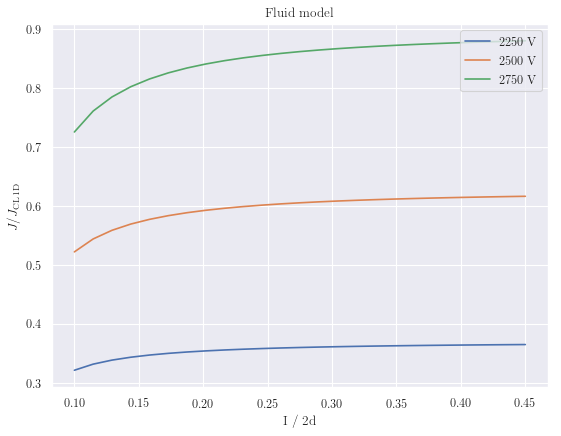

In [60]:
# Triangle length start, stop and number of steps
start = 200.0 # start [nm]
stop  = 900.0 # end [nm]
steps = 25 # steps

# Create array's to store results
cur_dens_1 = np.zeros(steps)
cur_dens_2 = np.zeros(steps)
cur_dens_3 = np.zeros(steps)
field_E    = np.zeros(steps)
a          = np.zeros(steps)

Set_System(2250.0, 1000.0)
for i in range(steps):
    # Calculate the triangle side length
    a[i] = start + (stop-start)/(steps-1)*i
    
    # Get the x, y coordinates of the emitters
    emitter_x, emitter_y, emitter_Lx, emitter_Ly, emitter_w = Triangle_emitters(a[i])
    
    # Scale the variables with d
    emitter_x  = emitter_x/d
    emitter_y  = emitter_y/d
    emitter_Lx = emitter_Lx/d
    emitter_Ly = emitter_Ly/d
    nrEmit     = len(emitter_x)

    J = np.zeros(nrEmit)
    E = np.zeros(nrEmit)
    
    # Do the fluid model calculations
    J, E = Do_Fluid_Model(emitter_x, emitter_y, emitter_Lx, emitter_Ly, emitter_w)
    
    # Return the current density of the center emitter, results are scaled in J_CL1D
    cur_dens_1[i] = np.mean(J[0:24])

Set_System(2500.0, 1000.0)
for i in range(steps):
    # Calculate the triangle side length
    a[i] = start + (stop-start)/(steps-1)*i
    
    # Get the x, y coordinates of the emitters
    emitter_x, emitter_y, emitter_Lx, emitter_Ly, emitter_w = Triangle_emitters(a[i])
    
    # Scale the variables with d
    emitter_x  = emitter_x/d
    emitter_y  = emitter_y/d
    emitter_Lx = emitter_Lx/d
    emitter_Ly = emitter_Ly/d
    nrEmit     = len(emitter_x)

    J = np.zeros(nrEmit)
    E = np.zeros(nrEmit)
    
    # Do the fluid model calculations
    J, E = Do_Fluid_Model(emitter_x, emitter_y, emitter_Lx, emitter_Ly, emitter_w)
    
    # Return the current density of the center emitter, results are scaled in J_CL1D
    cur_dens_2[i] = np.mean(J[0:24])
    
Set_System(2750.0, 1000.0)
for i in range(steps):
    # Calculate the triangle side length
    a[i] = start + (stop-start)/(steps-1)*i
    
    # Get the x, y coordinates of the emitters
    emitter_x, emitter_y, emitter_Lx, emitter_Ly, emitter_w = Triangle_emitters(a[i])
    
    # Scale the variables with d
    emitter_x  = emitter_x/d
    emitter_y  = emitter_y/d
    emitter_Lx = emitter_Lx/d
    emitter_Ly = emitter_Ly/d
    nrEmit     = len(emitter_x)

    J = np.zeros(nrEmit)
    E = np.zeros(nrEmit)
    
    # Do the fluid model calculations
    J, E = Do_Fluid_Model(emitter_x, emitter_y, emitter_Lx, emitter_Ly, emitter_w)
    
    # Return the current density of the center emitter, results are scaled in J_CL1D
    cur_dens_3[i] = np.mean(J[0:24])

# Plot the results
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=16)
fig = plt.figure(num=None, figsize=(8, 6), dpi=80)
ax = plt.subplot(111)
ax.plot(a/(2*d), cur_dens_1, label='2250 V')
ax.plot(a/(2*d), cur_dens_2, label='2500 V')
ax.plot(a/(2*d), cur_dens_3, label='2750 V')
ax.legend(loc='upper right')
plt.xlabel('I / 2d')
plt.ylabel(r'$J/J_{\rm CL\,1D}$')
plt.title('Fluid model')
plt.show()

In [61]:
np.savetxt('fluid_data_triangle.txt', np.array([a/(2*d), cur_dens_1, cur_dens_2, cur_dens_3]).T)

In [62]:
pwd

'/home/kristor/Work/data'

In [53]:
np.array([a, cur_dens_1, cur_dens_2, cur_dens_3]).T

(25, 4)

In [13]:
x_0 = 0.0
y_0 = 0.0
x_coor = np.array([])
y_coor = np.array([])
len_x = 20.0
len_y = 20.0

for i in range(-2, 2+1):
    for j in range(-2, 2+1):
        x_new = x_0 + len_x*i
        y_new = y_0 + len_y*j
        x_coor = np.append(x_coor, x_new)
        y_coor = np.append(y_coor, y_new)
        
for x, y in zip(x_coor, y_coor):
    print(str(x) + ' ,' + str(y))

-40.0 ,-40.0
-40.0 ,-20.0
-40.0 ,0.0
-40.0 ,20.0
-40.0 ,40.0
-20.0 ,-40.0
-20.0 ,-20.0
-20.0 ,0.0
-20.0 ,20.0
-20.0 ,40.0
0.0 ,-40.0
0.0 ,-20.0
0.0 ,0.0
0.0 ,20.0
0.0 ,40.0
20.0 ,-40.0
20.0 ,-20.0
20.0 ,0.0
20.0 ,20.0
20.0 ,40.0
40.0 ,-40.0
40.0 ,-20.0
40.0 ,0.0
40.0 ,20.0
40.0 ,40.0
